In [1]:
import time
import datetime
import pandas as pd
from neo_finrl.env_fx_trading.env_fx import tgym

In [2]:
import os
files=[]
for i in range(0,2): 
    file = f"./data/split/GBPUSD/weekly/GBPUSD_2017_{i}.csv"
    if os.path.isfile(file):
        files.append(file)
            
    else:
        print(f'not exist: {file}')
print(files)    


['./data/split/GBPUSD/weekly/GBPUSD_2017_0.csv', './data/split/GBPUSD/weekly/GBPUSD_2017_1.csv']


In [3]:
def train(env, agent, files, if_vix = True,**kwargs):
    learning_rate = kwargs.get('learning_rate', 2 ** -15)
    batch_size = kwargs.get('batch_size', 32 )
    gamma = kwargs.get('gamma', 0.99)
    seed = kwargs.get('seed', 312)
    total_timesteps = kwargs.get('total_timesteps', 1e6)
    net_dimension = kwargs.get('net_dimension', 2**9)
    cwd = kwargs.get('cwd','./'+str(agent))

    # env_instance = map(env, [pd.read_csv(f) for f in files])
    if agent == 'ppo':
        from stable_baselines3 import PPO
        from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv

        # env_train = [x.get_sb_env for x in env_instance ]
        vector_env = [lambda:env(df=pd.read_csv(f)) for f in files]
        env_train = SubprocVecEnv(vector_env)
        model = PPO("MlpPolicy", env_train, learning_rate=learning_rate, 
                    n_steps=2048, batch_size=batch_size, ent_coef=0.0, 
                    gamma=gamma, seed=seed)
        start_time = time.time()
        s = datetime.datetime.now()
        print(f'Training start: {s}')
        model.learn(total_timesteps=total_timesteps, tb_log_name = 'ppo')
        print('Training finished!')
        model_name = "./data/models/GBPUSD-week-" + s.strftime('%Y%m%d%H%M%S')
        model.save(model_name)
        print(f'Trained model saved in {model_name}')
        print(f"trainning time: {(time.time() - start_time)}")

    else:
        raise ValueError('DRL library input is NOT supported. Please check.')

In [ ]:
train(env=tgym,agent="ppo",files=files)

Training start: 2021-11-05 12:44:09.221870


In [ ]:
run at 10:36 to check loading time.

initial done:
observation_list:['Open', 'High', 'Low', 'Close', 'minute', 'hour', 'day', 'macd', 'boll_ub', 'boll_lb', 'rsi_30', 'dx_30', 'close_30_sma', 'close_60_sma']
 assets:['GBPUSD']
 time serial: 2017-01-09 00:00:00 -> 2017-01-13 23:55:00 length: 1440
plotting...


C:\github\NeoFinRL\.venv\lib\site-packages\mplfinance\_arg_validators.py:35: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+
C:\github\NeoFinRL\.venv\lib\site-packages\mplfinance\_arg_validators.py:35: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn

--- running time: 1.5830070972442627---


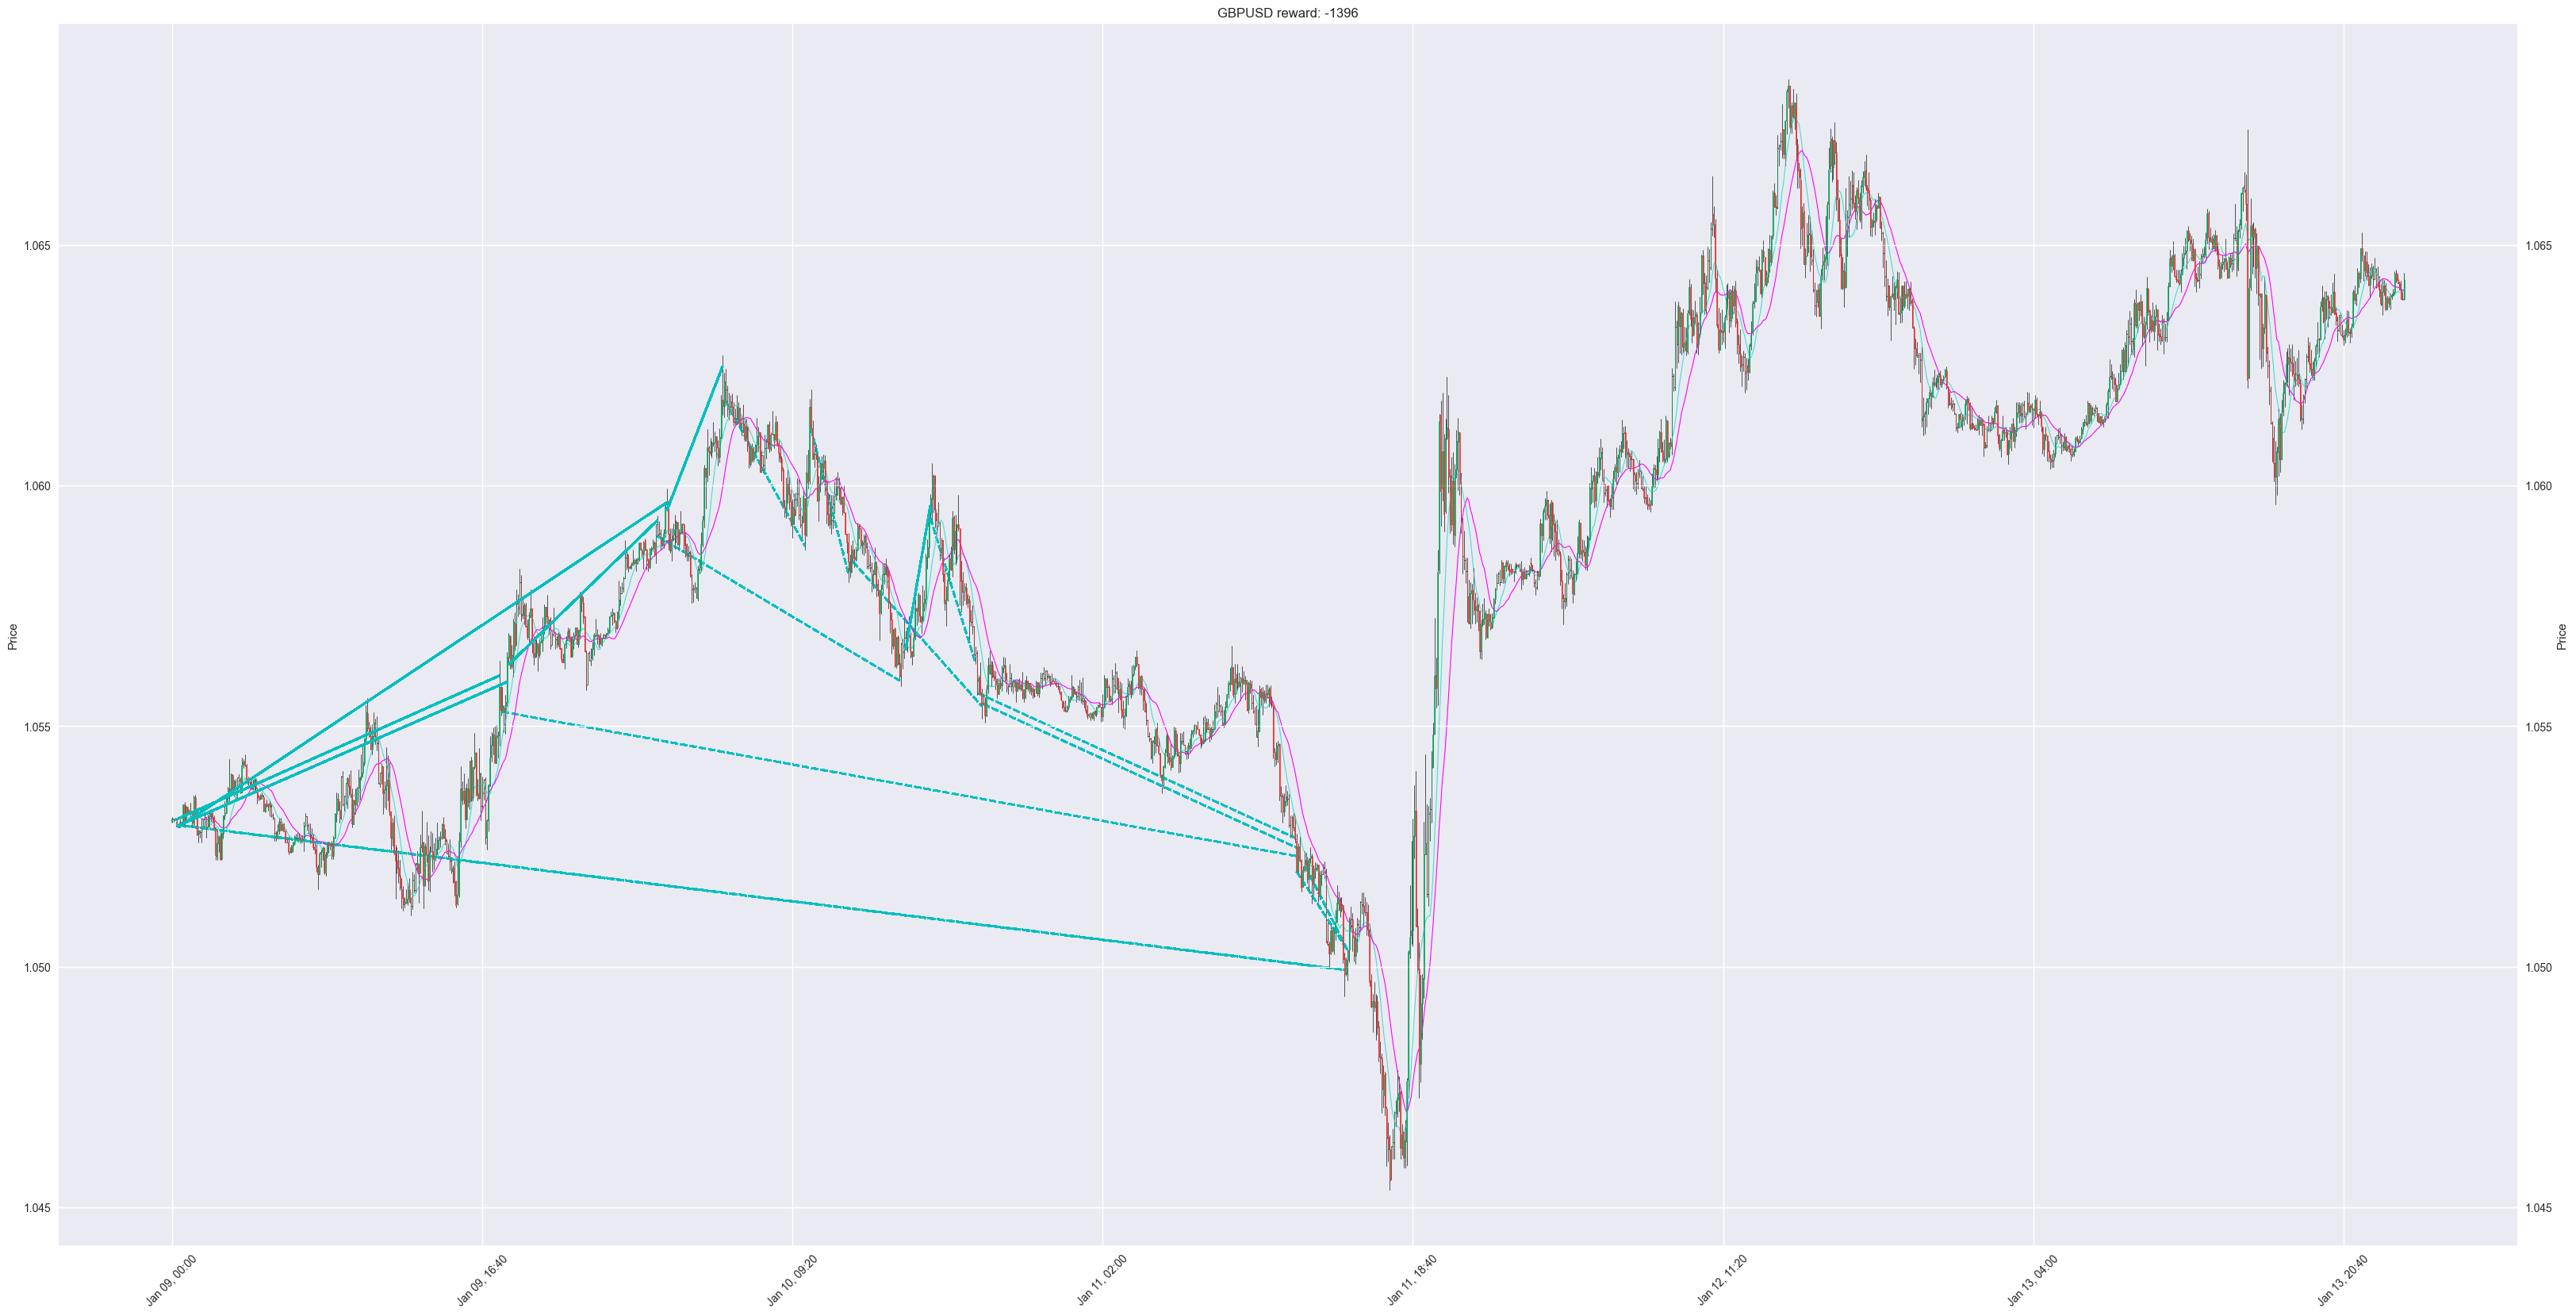

In [10]:
import pandas as pd
from neo_finrl.env_fx_trading.env_fx import tgym
import time
import datetime
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
file ="./data/split/GBPUSD/weekly/GBPUSD_2017_1.csv"
df = pd.read_csv(file)
t = tgym(df)

# if model: del model # remove to demonstrate saving and loading
model_name='./data/models/GBPUSD-week-20211105123141'
model = PPO.load(model_name)

start_time = time.time()
obs = t.reset()
t.current_step=0
done = False
while not done:
    action, _states = model.predict(obs)
    obs, rewards, done, info = t.step(action)
    t.render(mode='graph')
print(f"--- running time: {(time.time() - start_time)}---")